In [1]:
%matplotlib inline
import numpy
import pylab

sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)


In [2]:
from pycbc.waveform import get_td_waveform

In [3]:
apx = 'IMRPhenomD'

hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

Text(0, 0.5, 'Normalized amplitude')

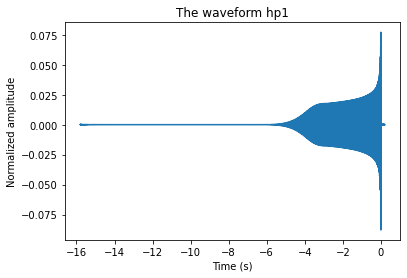

In [4]:
hp1 = hp1 / max(numpy.correlate(hp1,hp1, mode='full'))**0.5

pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')


Text(0, 0.5, 'Normalized amplitude')

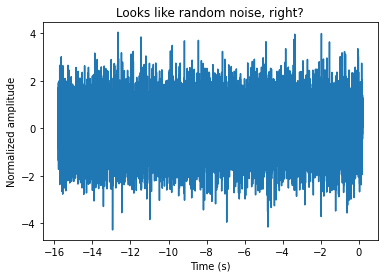

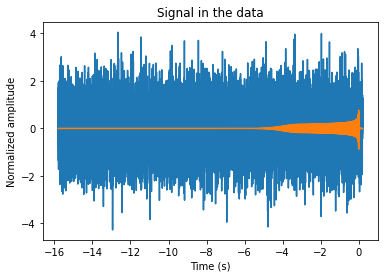

In [5]:
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')


Text(0, 0.5, 'Cross-correlation')

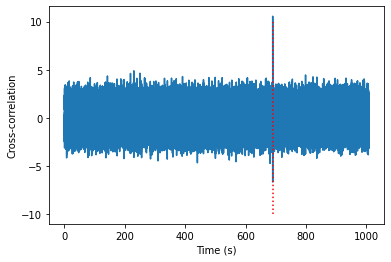

In [6]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

In [10]:
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

Text(0, 0.5, 'Cross-correlation')

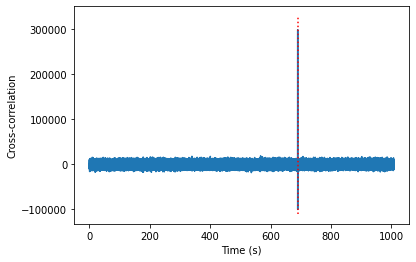

In [9]:
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

# Generate a PSD for whitening the data
from pycbc.types import TimeSeries
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# Set 0th and Nth value to avoid inf
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]

psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21

cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

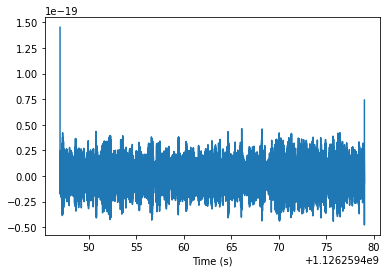

In [11]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

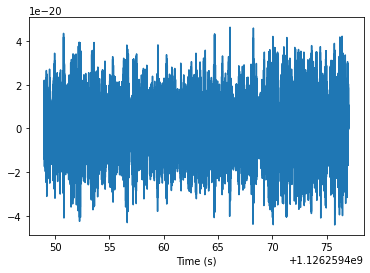

In [12]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()


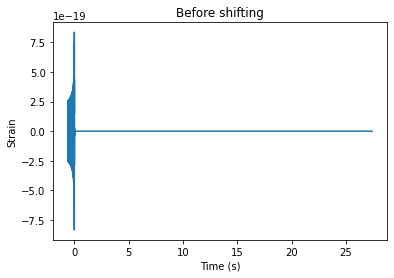

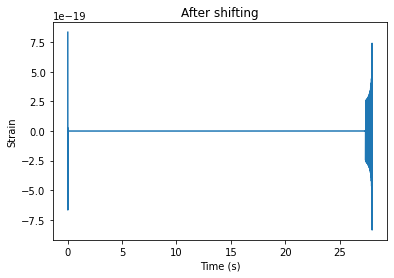

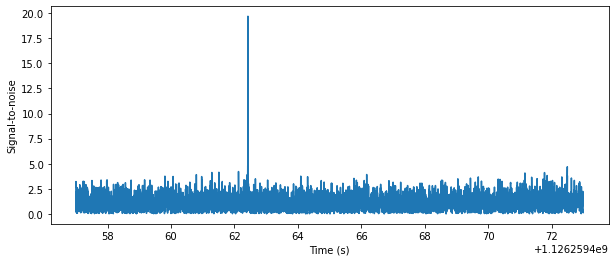

We found a signal at 1126259462.4248047s with SNR 19.678977177701537


In [13]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,low_frequency_cutoff=15)
from pycbc.waveform import get_td_waveform
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",mass1=m,mass2=m,delta_t=conditioned.delta_t,f_lower=20)
# We will resize the vector to match our data
hp.resize(len(conditioned))

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
                      
from pycbc.filter import matched_filter
snr = matched_filter(template, conditioned,psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp))) 

from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

In [28]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

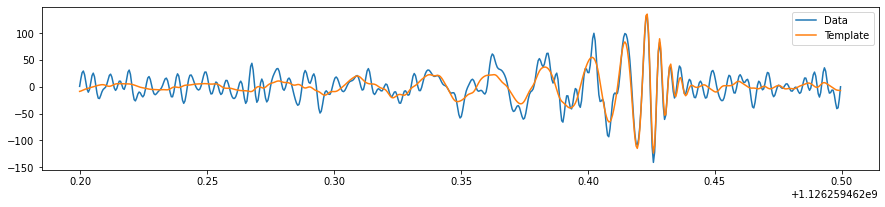

In [29]:
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()


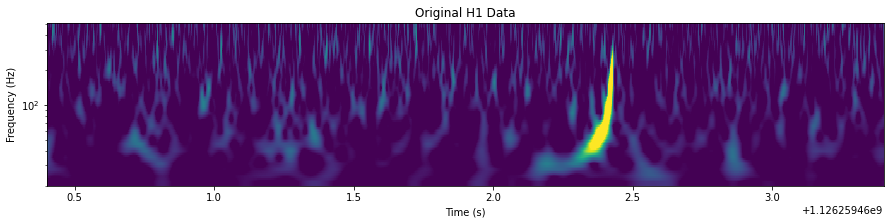

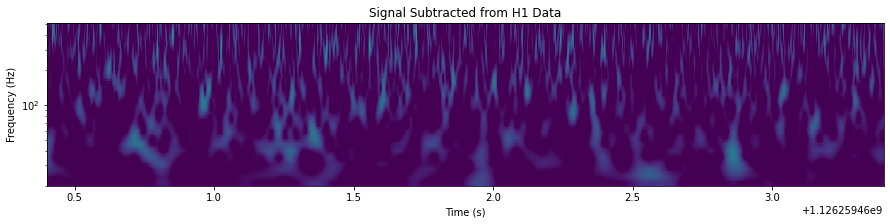

In [30]:
subtracted = conditioned - aligned

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,logfsteps=100,qrange=(8, 8),frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

In [50]:
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_2.gwf', 'PyCBC_T2_3.gwf']

for fname in files:
    get_file(fname)
    

# An example of how to read the data from these files:
file_name = "PyCBC_T2_3.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:TEST-STRAIN"

start = 0
end = start + 128

ts = read_frame(file_name, channel_name, start, end)

Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_0.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_2.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_3.gwf


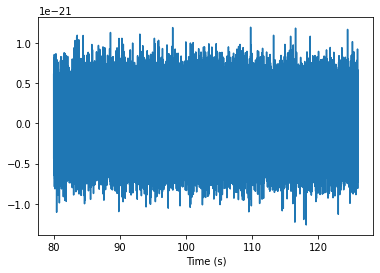

!!!! 121.91015625 (-4.088006948655351+0.8115627730835775j) 85832


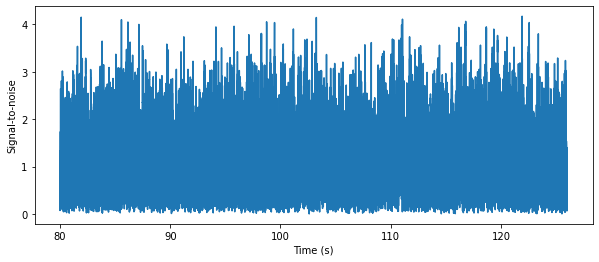

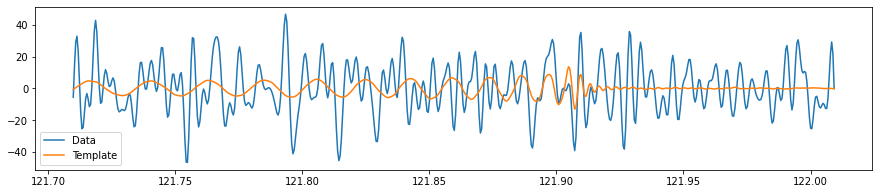

!!!! 116.064453125 (-1.7367979160173643+4.717890353352389j) 73860


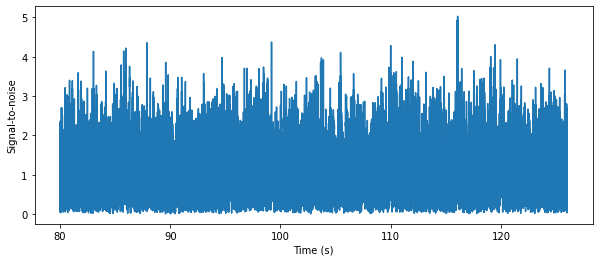

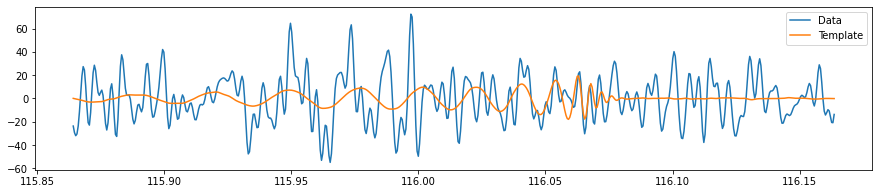

!!!! 115.99560546875 (-6.747037536398749+6.990371354939206j) 73719


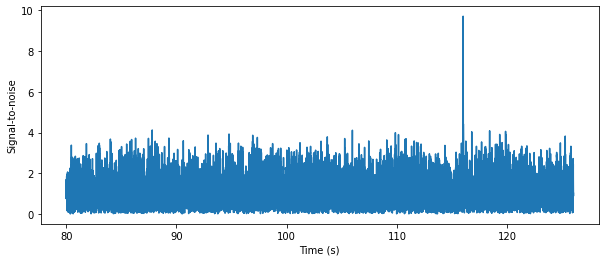

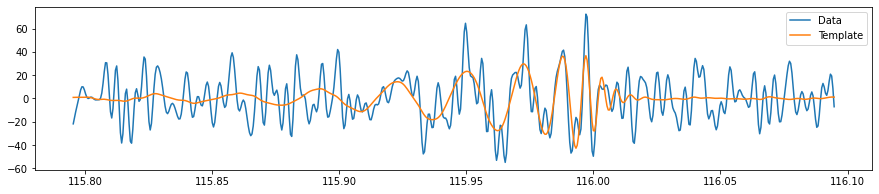

In [51]:
test1 = highpass(ts, 15.0)
test1 = resample_to_delta_t(test1, 1.0/2048)
test1 = test1.crop(80,2)
pylab.plot(test1.sample_times,test1)
pylab.xlabel('Time (s)')
pylab.show()
test1psd = test1.psd(4)
test1psd = interpolate(test1psd,test1.delta_f)
test1psd = inverse_spectrum_truncation(test1psd, 4 * conditioned.sample_rate,low_frequency_cutoff=15)

def check(iData,iDataPSD,iM):
    m = iM # Solar masses
    chp, chc = get_td_waveform(approximant="SEOBNRv4_opt",mass1=m,mass2=m,delta_t=iData.delta_t,f_lower=20)
    chp.resize(len(test1))
    test1template = chp.cyclic_time_shift(chp.start_time)
    csnr = matched_filter(test1template,iData,psd=iDataPSD, low_frequency_cutoff=20)

    cpeak = abs(csnr).numpy().argmax()
    csnrp = csnr[cpeak]
    ctime = csnr.sample_times[cpeak]
    print("!!!!",ctime,csnrp,cpeak)
    
    pylab.figure(figsize=[10, 4])
    pylab.plot(csnr.sample_times, abs(csnr))
    pylab.ylabel('Signal-to-noise')
    pylab.xlabel('Time (s)')
    pylab.show()

    cdt = ctime - iData.start_time
    caligned = test1template.cyclic_time_shift(cdt)
    caligned /= sigma(caligned, psd=iDataPSD, low_frequency_cutoff=20.0)
    caligned = (caligned.to_frequencyseries() * csnrp).to_timeseries()
    caligned.start_time = iData.start_time
    
    cwhite_data = (iData.to_frequencyseries() / iDataPSD**0.5).to_timeseries()
    cwhite_template = (caligned.to_frequencyseries() / iDataPSD**0.5).to_timeseries()
    cwhite_data = cwhite_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    cwhite_template = cwhite_template.highpass_fir(30, 512).lowpass_fir(300, 512)
    cwhite_data = cwhite_data.time_slice(ctime-.2, ctime+.1)
    cwhite_template = cwhite_template.time_slice(ctime-.2, ctime+.1)
    pylab.figure(figsize=[15, 3])
    pylab.plot(cwhite_data.sample_times, cwhite_data, label="Data")
    pylab.plot(cwhite_template.sample_times, cwhite_template, label="Template")
    pylab.legend()
    pylab.show()

check(test1,test1psd,22)
check(test1,test1psd,36)
check(test1,test1psd,50)

In [33]:
print(strain)

[ 1.45326106e-19  1.32074727e-19 -1.74255868e-20 ... -4.77718631e-20
  6.20883316e-20  7.41396636e-20]
